In [111]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import random

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [113]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None,num_per_class=3):
        self.data = ImageFolder(data_dir, transform=transform)

        class_indices = {}  
        selected_indices = []

        for idx, (_, label) in enumerate(self.data):
            if label not in class_indices:
                class_indices[label] = []
            if len(class_indices[label]) < num_per_class:
                class_indices[label].append(idx)
                selected_indices.append(idx)

        self.data = Subset(self.data, selected_indices)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

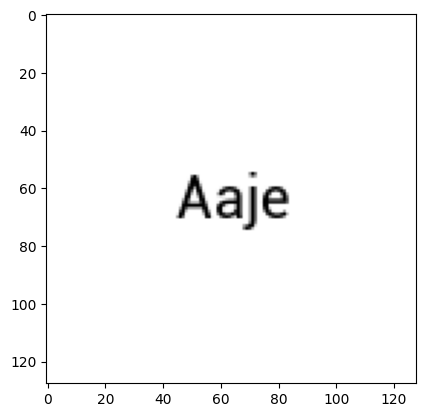

In [114]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset('train', transform=transform, num_per_class=20)
test_dataset = CustomDataset('test', transform=transform, num_per_class=10)

for img,label in train_dataset:
    plt.imshow(img[0], cmap='gray')
    plt.show()
    break

In [115]:
image, label = train_dataset[0]
print(image.shape)

len(train_dataset), len(test_dataset)

torch.Size([1, 128, 128])


(2000, 1000)

In [116]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [117]:
class MyNN(nn.Module):

    def __init__(self, input_features):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32,128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(64,100),
        )

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [118]:
epochs = 100
learning_rate = 0.01
model = MyNN(1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)
losses = []

In [119]:
for epoch in range(epochs):

    total_loss = 0
    for batch_features, batch_labels in train_dataloader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        #forward pass

        outputs = model(batch_features)

        # calculate loss

        loss = criterion(outputs,batch_labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        #update grads
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss/len(train_dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 4.666429943508572
Epoch 2, Loss: 4.609864159235879
Epoch 3, Loss: 4.60935432191879
Epoch 4, Loss: 4.609962463378906
Epoch 5, Loss: 4.608980050162663
Epoch 6, Loss: 4.608033490559412
Epoch 7, Loss: 4.6090950890192905
Epoch 8, Loss: 4.6085020322648305
Epoch 9, Loss: 4.6077644030253095
Epoch 10, Loss: 4.6084962420993385
Epoch 11, Loss: 4.607241562434605
Epoch 12, Loss: 4.608667615860227
Epoch 13, Loss: 4.607113868471176
Epoch 14, Loss: 4.6084812179444326
Epoch 15, Loss: 4.608295917510986
Epoch 16, Loss: 4.607183993808807
Epoch 17, Loss: 4.6080170510307195
Epoch 18, Loss: 4.60739483152117
Epoch 19, Loss: 4.606725904676649
Epoch 20, Loss: 4.606663378458174
Epoch 21, Loss: 4.6055261672489225
Epoch 22, Loss: 4.608299558124845
Epoch 23, Loss: 4.60717198962257
Epoch 24, Loss: 4.607831039125958
Epoch 25, Loss: 4.606226171766009
Epoch 26, Loss: 4.607564169263083
Epoch 27, Loss: 4.608162213885595
Epoch 28, Loss: 4.606514741504003
Epoch 29, Loss: 4.607010008796813
Epoch 30, Loss: 4.6

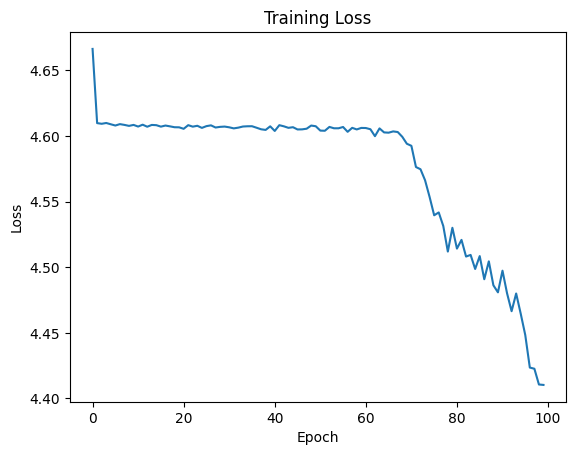

In [120]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [121]:
model.eval()

total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs,1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

print(100*(correct/total))

2.1999999999999997


In [122]:
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs,1)
        
        for i in range(batch_features.size(0)):
            print(predicted[i].item(), batch_labels[i].item())

17 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
96 1
96 1
96 1
96 1
96 1
96 1
96 1
96 1
70 1
96 1
96 2
96 2
96 2
96 2
96 2
70 2
96 2
70 2
96 2
96 2
17 3
17 3
17 3
17 3
17 3
17 3
17 3
17 3
17 3
17 3
70 4
25 4
70 4
70 4
70 4
70 4
96 4
70 4
70 4
70 4
70 5
70 5
70 5
70 5
70 5
70 5
70 5
96 5
96 5
70 5
17 6
17 6
17 6
17 6
17 6
17 6
17 6
17 6
17 6
17 6
25 7
70 7
25 7
25 7
25 7
17 7
25 7
25 7
25 7
11 7
17 8
17 8
17 8
17 8
17 8
17 8
17 8
17 8
17 8
17 8
17 9
17 9
17 9
17 9
17 9
17 9
17 9
17 9
17 9
17 9
70 10
17 10
70 10
17 10
25 10
17 10
25 10
17 10
70 10
25 10
96 11
96 11
96 11
96 11
96 11
70 11
96 11
70 11
96 11
70 11
17 12
17 12
17 12
17 12
17 12
17 12
17 12
17 12
17 12
17 12
17 13
17 13
17 13
17 13
17 13
17 13
17 13
17 13
17 13
17 13
25 14
25 14
25 14
25 14
25 14
17 14
25 14
25 14
25 14
17 14
17 15
17 15
17 15
17 15
17 15
17 15
17 15
17 15
17 15
17 15
17 16
17 16
17 16
17 16
17 16
17 16
17 16
17 16
17 16
17 16
25 17
17 17
17 17
17 17
25 17
17 17
25 17
17 17
25 17
17 17
17 18
17 18
17 18
17